In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets

from loguru import logger
from faisst_denstream.DenStream import DenStream
from random import random
from sys import stdout
from sklearn.model_selection import ParameterGrid
from dbcv import dbcv
from collections import Counter
from random import randint

In [2]:
logger.remove()

<Axes: >

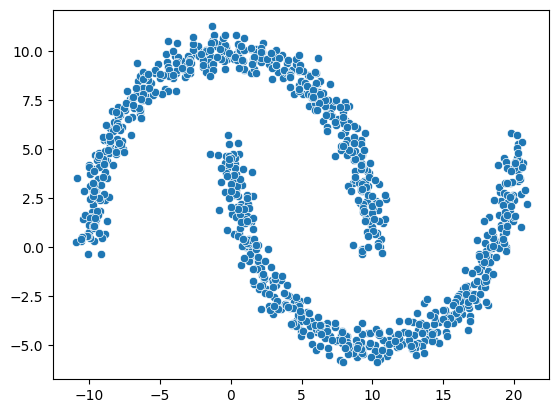

In [3]:
data, _ = sklearn.datasets.make_moons(n_samples=1000, noise=0.05)
data *= 10
np.random.shuffle(data)

sns.scatterplot(x=data[:,0], y=data[:,1])

In [4]:
def clustering_grid_search(model_class, data, param_grid):
    best_score = -1
    best_params = None
    best_model = None

    grid = ParameterGrid(param_grid)
    for i, params in enumerate(grid):
        try:
            model = model_class(**params)
            labels = model.fit_predict(data)
    
            # Silhouette score requires at least 2 clusters
            num_clusters = len(set([l for l in labels if l != -1]))
            if num_clusters > 1:
                score = dbcv(data, labels, check_duplicates=False)
            else:
                score = -1

            print(f"{i+1}/{len(grid)}: DBCV: {score:.4f}\tnum clusters: {num_clusters}")
    
            if score > best_score:
                best_score = score
                best_params = params
                best_model = model
        except:
            print(f"{i+1}/{len(grid)}: error")
            continue

    return best_model, best_params, best_score

In [5]:
grid = {
    "lamb": [0.01],
    "mu": [10, 50, 60, 100],
    "beta": [0.2, 0.3, 0.5, 0.7],
    "epsilon": [3, 4, 5, 10, 15],
    "n_init_points": [100],
    "stream_speed": [1],
    "radius_multiplier": [1, 1.5, 2, 2.5, 3]
}

best_model, best_params, best_score = clustering_grid_search(DenStream, data, grid)
print(best_score)
print(best_params)

1/400: DBCV: -0.2136	num clusters: 6
2/400: DBCV: -0.1432	num clusters: 7
3/400: DBCV: 0.8653	num clusters: 2
4/400: DBCV: 0.8653	num clusters: 2
5/400: DBCV: 0.8653	num clusters: 2
6/400: DBCV: -1.0000	num clusters: 0
7/400: DBCV: -1.0000	num clusters: 0
8/400: DBCV: -1.0000	num clusters: 0
9/400: DBCV: -1.0000	num clusters: 0
10/400: DBCV: -1.0000	num clusters: 0
11/400: DBCV: -1.0000	num clusters: 0
12/400: DBCV: -1.0000	num clusters: 0
13/400: DBCV: -1.0000	num clusters: 0
14/400: DBCV: -1.0000	num clusters: 0
15/400: DBCV: -1.0000	num clusters: 0
16/400: error
17/400: error
18/400: error
19/400: error
20/400: error
21/400: DBCV: -0.4153	num clusters: 9
22/400: DBCV: -0.3723	num clusters: 7
23/400: DBCV: 0.8653	num clusters: 2
24/400: DBCV: 0.8653	num clusters: 2
25/400: DBCV: -1.0000	num clusters: 1
26/400: DBCV: -1.0000	num clusters: 0
27/400: DBCV: -1.0000	num clusters: 0
28/400: DBCV: -1.0000	num clusters: 0
29/400: DBCV: -1.0000	num clusters: 0
30/400: DBCV: -1.0000	num cluste

In [6]:
preds = best_model.predict(data)

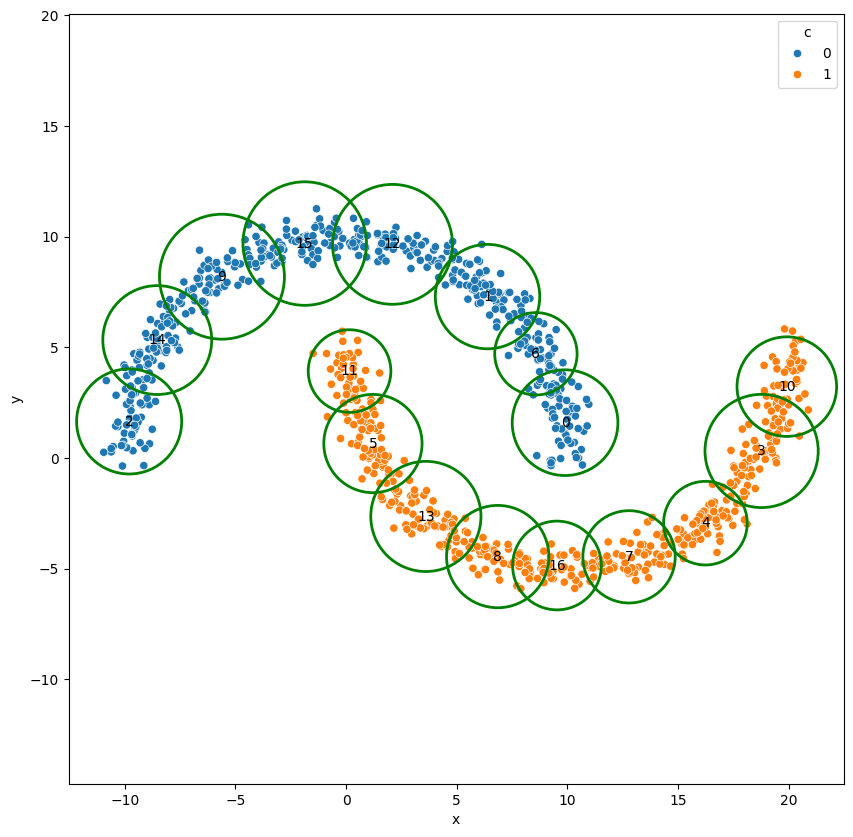

In [8]:
points = []
clusters = []
for point, pred in zip(data, preds):
    points.append(point)
    clusters.append(pred)

out = pd.DataFrame(data=points, columns=['x', 'y'])
out['c'] = clusters

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=out, x='x', y='y', hue='c', palette='tab10')

for i, pmc in enumerate(best_model.pmc):
    ax.text(pmc.center[0], pmc.center[1], str(i), ha='center', va='center', color='black')
    ax.add_patch(plt.Circle(pmc.center, pmc.radius, color='green', fill=False, lw=2))

for i, omc in enumerate(best_model.omc):
    ax.text(omc.center[0], omc.center[1], str(i), ha='center', va='center', color='black')
    ax.add_patch(plt.Circle(omc.center, omc.radius, color='red', fill=False, lw=2))

ax.set_aspect('equal', adjustable='datalim')